In [47]:
# Dataset Link
# https://www.kaggle.com/datasets/samuelcortinhas/cats-and-dogs-image-classification

In [1]:
# ==============================
# Importing Required Libraries
# ==============================

import numpy as np                     # For numerical operations and array handling
import pandas as pd                    # For working with tabular data (if dataset is in CSV/Excel format)
import tensorflow as tf                # TensorFlow framework for deep learning
from tensorflow import keras           # Keras high-level API inside TensorFlow
import os                              # For file and directory management
import zipfile                         # To extract datasets if they are in .zip format

import matplotlib.pyplot as plt        # For data visualization (plots, graphs)
import matplotlib.image as img         # For loading and displaying images with matplotlib
import seaborn as sns                  # For advanced visualizations (heatmaps, pairplots, etc.)

# ==============================
# Keras Image Preprocessing
# ==============================

from keras.preprocessing.image import load_img     # To load an image from disk
from keras.preprocessing.image import img_to_array # To convert an image into a NumPy array (for model input)

# ==============================
# Pre-trained VGG16 Network Utilities
# ==============================

from keras.applications.vgg16 import preprocess_input  # Preprocess images the same way VGG16 was trained
from keras.applications.vgg16 import decode_predictions # Decode model predictions into human-readable labels
from keras.applications.vgg16 import VGG16             # Pre-trained VGG16 model (trained on ImageNet)

# ==============================
# Keras Layers and Model Customization
# ==============================

from keras.layers import Dense, Flatten   # Dense (fully connected) layer, Flatten to convert feature maps into vector
from keras.models import Model            # To define custom models based on VGG16

# ==============================
# Training Utilities
# ==============================

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# EarlyStopping: stops training when validation performance stops improving
# ReduceLROnPlateau: reduces learning rate when validation performance stagnates

# ==============================
# Data Splitting & Augmentation
# ==============================

from sklearn.model_selection import train_test_split        # To split dataset into training and validation sets
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# ImageDataGenerator: generates batches of image data with real-time data augmentation (rotation, zoom, flip, etc.)

# ==============================
# Setting Random Seed for Reproducibility
# ==============================

seed = 0                 # Define a seed value
np.random.seed(seed)     # Apply the seed for NumPy (ensures reproducible random operations)


2025-08-31 20:36:20.408185: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756672580.626554      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756672580.691188      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Define the path to the training dataset directory
TRAIN_DIR_PATH = '/kaggle/input/cats-and-dogs-image-classification/train'

# Get a list of all files (image filenames) present in the training directory
cat_files_names = os.listdir("/kaggle/input/cats-and-dogs-image-classification/train/cats")
dog_files_names = os.listdir("/kaggle/input/cats-and-dogs-image-classification/train/dogs")
# Print the total number of images found in the training folder
print('There are {} number of cat images in directory.'.format(len(cat_files_names)))
print('There are {} number of dog images in directory.'.format(len(dog_files_names)))


There are 279 number of cat images in directory.
There are 278 number of dog images in directory.


In [3]:
# Function to convert a list of image filenames into a pandas DataFrame
def to_dataframe(file_names):
    # Initialize two empty lists to hold filenames and corresponding labels
    files, labels = list(), list()
    
    # Loop over every filename in the given list
    for file in file_names:
        files.append(file)          # Add the full filename to the 'files' list
        labels.append(file[:3])     # Extract the first 3 characters of the filename as the label
                                    # Example: "cat.123.jpg" -> "cat", "dog.456.jpg" -> "dog"
    
    # Create a DataFrame with two columns: 'filename' and 'label'
    df = pd.DataFrame({'filename': files, 'label': labels})
    
    # Return the constructed DataFrame
    return df

# Call the function to create a DataFrame from the list of training file names
cat_df = to_dataframe(cat_files_names)
dog_df = to_dataframe(dog_files_names)

In [4]:
cat_df

,filename,label
0,cat_511.jpg,cat
1,cat_78.jpg,cat
2,cat_77.jpg,cat
3,cat_141.jpg,cat
4,cat_362.jpg,cat
...,...,...
274,cat_200.jpg,cat
275,cat_402.jpg,cat
276,cat_149.jpg,cat
277,cat_222.jpg,cat


In [5]:
dog_df

,filename,label
0,dog_221.jpg,dog
1,dog_188.jpg,dog
2,dog_294.jpg,dog
3,dog_77.jpg,dog
4,dog_35.jpg,dog
...,...,...
273,dog_448.jpg,dog
274,dog_138.jpg,dog
275,dog_371.jpg,dog
276,dog_82.jpg,dog


In [6]:
# ==============================
# Concatenate the DataFrames
# ==============================
combined_df = pd.concat([dog_df, cat_df], ignore_index=True)

# ==============================
# Shuffle the DataFrame
# ==============================
df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Show result
df

,filename,label
0,dog_338.jpg,dog
1,cat_46.jpg,cat
2,dog_451.jpg,dog
3,dog_67.jpg,dog
4,dog_23.jpg,dog
...,...,...
552,dog_408.jpg,dog
553,dog_156.jpg,dog
554,dog_162.jpg,dog
555,cat_159.jpg,cat


data set label distribution:
 label
cat    279
dog    278
Name: count, dtype: int64


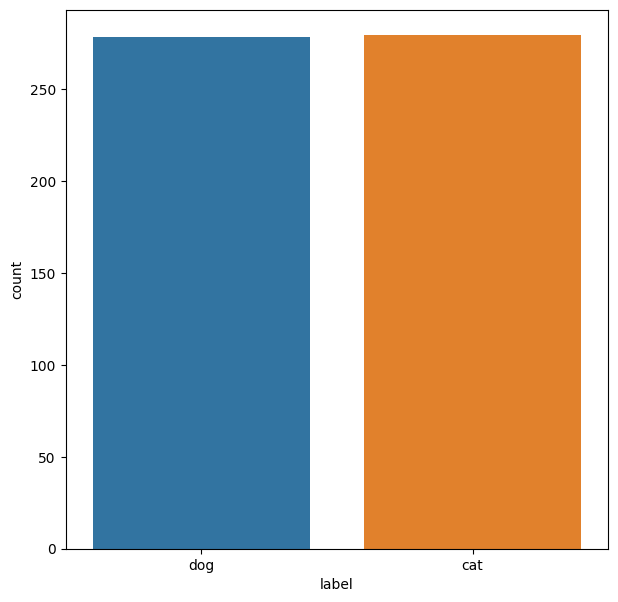

In [7]:
print('data set label distribution:\n',df['label'].value_counts())

plt.figure(figsize=(7,7))
sns.countplot(x = df['label'])
plt.show()

In [8]:
# Randomly print a CAT Image
cat_train_path = "/kaggle/input/cats-and-dogs-image-classification/train/cats/"
im = img.imread(cat_train_path + cat_files_names[0])
im

array([[[194, 166, 152],
        [200, 172, 158],
        [191, 163, 149],
        ...,
        [174, 139,  97],
        [170, 135,  93],
        [172, 137,  95]],

       [[192, 164, 150],
        [199, 171, 157],
        [192, 164, 150],
        ...,
        [178, 143, 101],
        [177, 142, 100],
        [179, 144, 102]],

       [[193, 165, 153],
        [200, 172, 160],
        [196, 168, 156],
        ...,
        [180, 145, 103],
        [183, 148, 106],
        [183, 148, 106]],

       ...,

       [[234, 195, 178],
        [235, 196, 179],
        [234, 195, 178],
        ...,
        [ 91,  77,  76],
        [ 91,  77,  76],
        [ 94,  80,  79]],

       [[250, 211, 194],
        [241, 202, 185],
        [236, 197, 180],
        ...,
        [ 88,  74,  73],
        [ 87,  73,  72],
        [ 90,  76,  75]],

       [[245, 206, 189],
        [231, 192, 175],
        [227, 188, 171],
        ...,
        [ 98,  84,  83],
        [ 99,  85,  84],
        [104,  90,  89]]

(1080, 1920, 3)


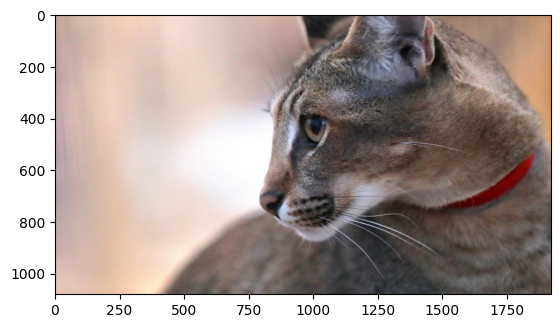

In [9]:
print(im.shape)
plt.imshow(im)
plt.show()

In [ ]:
dog_train_path = "/kaggle/input/cats-and-dogs-image-classification/train/dogs/"
im = img.imread(dog_train_path + dog_files_names[0])
im

(208, 243, 3)


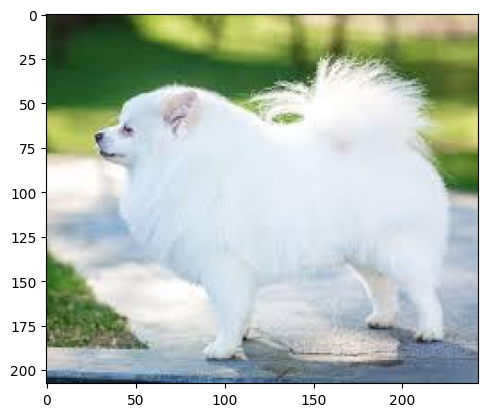

In [11]:
print(im.shape)
plt.imshow(im)
plt.show()

In [12]:
image_name = "/kaggle/input/cats-and-dogs-image-classification/train/cats/cat_102.jpg"
img = load_img(image_name)

In [13]:
type(img)

PIL.JpegImagePlugin.JpegImageFile

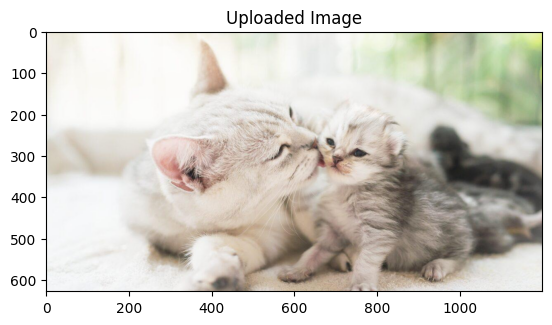

In [14]:
plt.imshow(img)
plt.title("Uploaded Image")
plt.show();

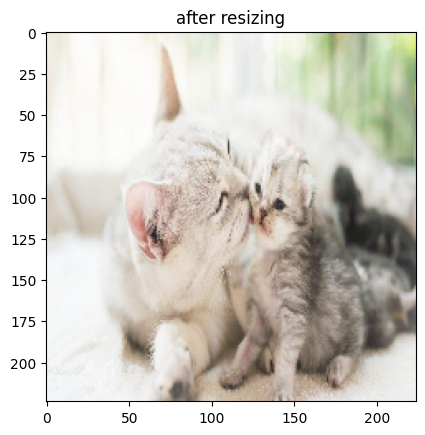

In [15]:
img = load_img(image_name, target_size=(224, 224))
plt.imshow(img)
plt.title("after resizing")
plt.show();

In [16]:
# weights="imagenet" → loads pretrained weights from ImageNet (1.2M images, 1000 classes)
# include_top=True → keeps the fully connected layers (the "top") used for classification into 1000 ImageNet classes
# input_shape=(224,224,3) → sets the input size of the images (224x224 pixels with 3 color channels: RGB)
full_model = VGG16(weights="imagenet",
                   include_top=True,
                   input_shape=(224, 224, 3))

# ===============================================
# Print the model architecture
# ===============================================
full_model.summary()  # Displays each layer, output shape, and number of parameters

I0000 00:00:1756672595.892145      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
"""# weights="imagenet": This specifies that the model should be loaded with pre-trained weights from the ImageNet dataset. 
    The ImageNet dataset is a large visual database used to train models for various image classification tasks.
   # include_top=True: This indicates that the fully connected layers at the top of the network (used for classification) 
   should be included. Since the model was trained on ImageNet, it has 1000 output classes corresponding to different object categories.
   input_shape=(224, 224, 3): This specifies the shape of the input images expected by the model. The images should be 224x224 pixels with 3 color channels (RGB)."""
full_model = VGG16(weights = "imagenet", include_top=True, input_shape =(224,224, 3))
image = img_to_array(img)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
"""
This function from Keras preprocesses the image for the VGG16 model. 
The preprocessing involves scaling pixel values and possibly other normalization steps 
that match the preprocessing used during the original training of the VGG16 model."""
image = preprocess_input(image)

In [18]:
yhat = full_model.predict(image)

I0000 00:00:1756672616.045542      99 service.cc:148] XLA service 0x7c576800aa20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756672616.046425      99 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1756672616.201524      99 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


I0000 00:00:1756672618.140112      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [19]:
yhat.shape

(1, 1000)

In [20]:
yhat[:,:10]

array([[3.1470977e-06, 3.0551117e-05, 2.3309167e-05, 1.8115445e-05,
        1.0784758e-05, 3.9182905e-05, 1.6496266e-05, 5.9646885e-03,
        7.2737589e-02, 3.1660616e-03]], dtype=float32)

In [21]:
""", it returns the top 5 predictions, but you can specify a different number by passing 
a top argument,like decode_predictions(yhat, top=3) for the top 3 predictions."""
label = decode_predictions(yhat)

35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [22]:
"""It's typically a list of tuples, where each tuple contains:
The ImageNet class ID.
The human-readable class name.
The confidence score (probability) for that class"""
label

[[('n02124075', 'Egyptian_cat', 0.17464405),
  ('n02127052', 'lynx', 0.07783815),
  ('n01514859', 'hen', 0.07273759),
  ('n02123045', 'tabby', 0.060664013),
  ('n02328150', 'Angora', 0.05915072)]]

In [23]:
label = label[0][0]
print('%s (%.2f%%)' % (label[1], label[2]*100))

Egyptian_cat (17.46%)


In [24]:
features_extractor = VGG16(weights = "imagenet", include_top=False, input_shape = (224,224, 3))
features_extractor.summary()#note the number of trainable parameters

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
for layer in features_extractor.layers:
    layer.trainable = False
features_extractor.summary()#note the number of non trainable parameters

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [26]:
last_layer = features_extractor.get_layer('block5_pool')
last_output = last_layer.output
x = Flatten()(last_output)
x = Dense(2, activation='softmax', name='softmax')(x)
new_model = Model(inputs=features_extractor.input, outputs=x)
new_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Dense)                 │ (None, 2)              │        50,178 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,764,866 (56.32 MB)

 Trainable params: 50,178 (196.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

#### Feature selector trainer

In [27]:
train_set, valid_set = train_test_split(df, test_size=0.2,random_state=seed)

In [28]:
train_set.shape, valid_set.shape

((445, 2), (112, 2))

In [29]:
train_set

,filename,label
518,dog_448.jpg,dog
553,dog_156.jpg,dog
282,cat_139.jpg,cat
162,dog_570.jpg,dog
554,dog_162.jpg,dog
...,...,...
70,cat_293.jpg,cat
277,dog_272.jpg,dog
9,dog_409.jpg,dog
359,dog_178.jpg,dog


train set distribution:
 label
cat    225
dog    220
Name: count, dtype: int64

valid set distribution:
 label
dog    58
cat    54
Name: count, dtype: int64



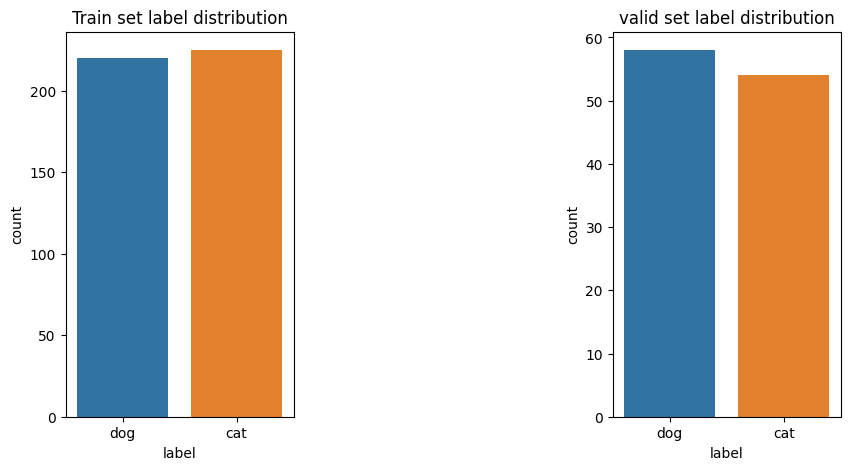

In [30]:
print('train set distribution:\n',train_set['label'].value_counts())
print('\nvalid set distribution:\n',valid_set['label'].value_counts())
print()

plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
sns.countplot(x=train_set['label'], order=['dog','cat'])
plt.title('Train set label distribution')

plt.subplot(1,3,3)
sns.countplot(x=valid_set['label'], order=['dog','cat'])
plt.title('valid set label distribution')
plt.show()

In [31]:
WIDTH, HEIGHT = 224, 224
batch_size = 32

In [32]:
# Import ImageDataGenerator for data augmentation and preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the target image width and height for resizing
WIDTH, HEIGHT = 224, 224

# Define the batch size (number of images processed at once during training)
batch_size = 32

# Create an ImageDataGenerator object with real-time data augmentation
# This helps improve generalization by applying random transformations to training images
train_datagenerator = ImageDataGenerator(
    rotation_range=15,        # Randomly rotate images by up to 15 degrees
    rescale=1./255,           # Normalize pixel values to the range [0, 1]
    shear_range=0.1,          # Apply random shear transformations
    zoom_range=0.2,           # Randomly zoom in on images (up to 20%)
    horizontal_flip=True,     # Randomly flip images horizontally
    width_shift_range=0.1,    # Randomly shift the image horizontally (10% of total width)
    height_shift_range=0.1,   # Randomly shift the image vertically (10% of total height)
    validation_split=0.2      # Split dataset into training (80%) and validation (20%)
)

# Create the training data generator
training_data = train_datagenerator.flow_from_directory(
    directory='/kaggle/input/cats-and-dogs-image-classification/train', # Path to training dataset
    target_size=(WIDTH, HEIGHT),   # Resize images to match model input (224x224)
    batch_size=batch_size,         # Number of images per batch
    class_mode='categorical',      # Use categorical labels (one-hot encoded for multiple classes)
    subset='training'              # Use the training subset (80% of data)
)

# Create the validation data generator
validation_data = train_datagenerator.flow_from_directory(
    directory='/kaggle/input/cats-and-dogs-image-classification/train', # Same dataset directory
    target_size=(WIDTH, HEIGHT),   # Resize images to 224x224
    batch_size=batch_size,         # Number of images per batch
    class_mode='categorical',      # One-hot encoded labels
    subset='validation'            # Use the validation subset (20% of data)
)


Found 447 images belonging to 2 classes.
Found 110 images belonging to 2 classes.


In [33]:
training_data.class_indices

{'cats': 0, 'dogs': 1}

In [34]:
training_data.filenames[:10]

['cats/cat_209.jpg',
 'cats/cat_21.jpg',
 'cats/cat_211.jpg',
 'cats/cat_213.jpg',
 'cats/cat_214.jpg',
 'cats/cat_215.jpg',
 'cats/cat_217.jpg',
 'cats/cat_218.jpg',
 'cats/cat_219.jpg',
 'cats/cat_220.jpg']

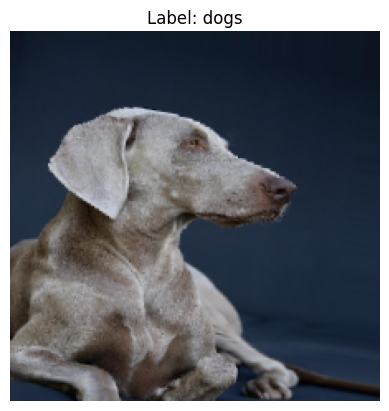

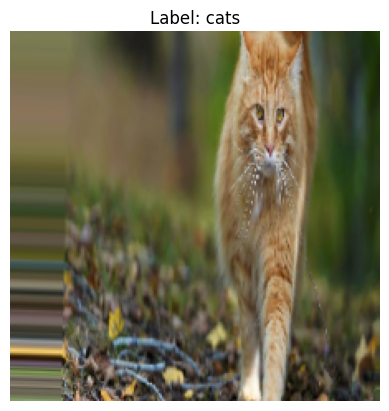

In [35]:
# Iterate through batches in the training_data generator
for i in range(len(training_data.filenames)):
    # Get the next batch of images and labels
    images, labels = next(training_data)  
    
    # Take the first image from the batch
    img = images[0]
    
    # Convert the one-hot encoded label back to a class index
    class_index = np.argmax(labels[0])
    
    # Map the class index to the actual class name using class_indices
    # class_indices maps: {'cat': 0, 'dog': 1}
    class_labels = {v: k for k, v in training_data.class_indices.items()}
    
    # Display the image
    plt.imshow(img)
    plt.title(f"Label: {class_labels[class_index]}")
    plt.axis("off")
    plt.show()
    
    # Break after showing the first image to avoid looping through all images
    if i > 0:
        break


In [36]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Stop training when validation loss does not improve for 10 epochs
# and restore the best weights (not the last ones).
earlystop_cb = EarlyStopping(
    patience=10,               # Number of epochs with no improvement before stopping
    monitor='val_loss',        # Metric to monitor (here: validation loss)
    restore_best_weights=True  # Roll back to the best weights seen during training
)

# Reduce learning rate when validation loss stops improving
reduce_lr_cb = ReduceLROnPlateau(
    factor=0.5,         # Reduce LR by half when triggered
    patience=5,         # Wait for 5 epochs with no improvement before reducing LR
    monitor='val_loss', # Metric to monitor
    min_lr=0.00001      # Do not reduce LR below this threshold
)

# Collect the callbacks into a list to pass into model.fit()
callbacks = [earlystop_cb, reduce_lr_cb]


In [37]:
opt = keras.optimizers.Adam(learning_rate=0.001)

In [38]:
new_model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

In [39]:
history = new_model.fit(training_data,
                   epochs=10,
                   validation_data=validation_data,
                     validation_steps=10,#This defines the number of batches of validation data that the model will evaluate at the end of each epoch.
                     steps_per_epoch=10, #This defines the number of batches of training data to be processed before the epoch is considered finished.
                                        #If your training_data is a generator or a dataset, steps_per_epoch=10 means 
                                        #that the model will run 10 batches per epoch.
                   callbacks=callbacks)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.5998 - loss: 1.0120 - val_accuracy: 0.7000 - val_loss: 0.5648 - learning_rate: 0.0010
Epoch 2/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step - accuracy: 0.8234 - loss: 0.4193 - val_accuracy: 0.7273 - val_loss: 0.6126 - learning_rate: 0.0010
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 665ms/step - accuracy: 0.8270 - loss: 0.3984 - val_accuracy: 0.8273 - val_loss: 0.4417 - learning_rate: 0.0010
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 277ms/step - accuracy: 0.7927 - loss: 0.5048 - val_accuracy: 0.7545 - val_loss: 0.5251 - learning_rate: 0.0010
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 629ms/step - accuracy: 0.8140 - loss: 0.3942 - val_accuracy: 0.7909 - val_loss: 0.5340 - learning_rate: 0.0010
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 280ms/step - accuracy: 0.7912 - loss: 0.4509 - val_accuracy: 0.7909 - val_loss: 0.5599 - learning_rate: 0.0010
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 640ms/step - accuracy: 0.8445 - loss: 0.3211 - val_accuracy: 0.8182 - val_loss: 0.4519 - learning_rate: 0.0010
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 295ms/step - accuracy: 0.8914 - loss: 0.2837 - val_accurac

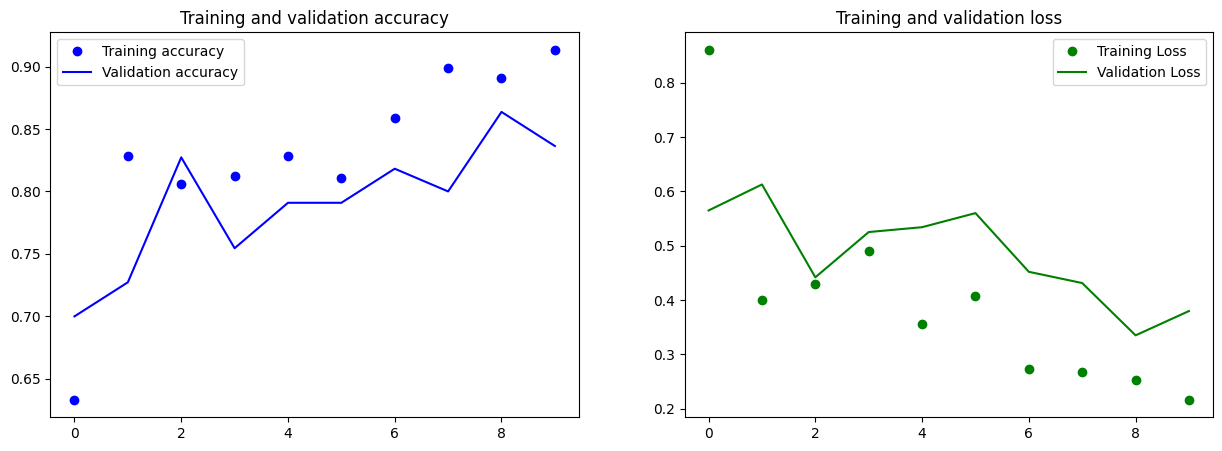

In [40]:
# Extract accuracy and loss values from training history
acc = history.history['accuracy']        # Training accuracy per epoch
val_acc = history.history['val_accuracy']# Validation accuracy per epoch
loss = history.history['loss']           # Training loss per epoch
val_loss = history.history['val_loss']   # Validation loss per epoch

# Number of epochs = length of accuracy list
epochs = range(len(acc))

# Create a figure with size (width=15, height=5)
plt.figure(figsize=(15,5))

# ----------------------- Plot Accuracy -----------------------
plt.subplot(1,2,1)                        # 1 row, 2 columns, 1st plot
plt.plot(epochs, acc, 'bo', label='Training accuracy')   # 'bo' = blue dots
plt.plot(epochs, val_acc, 'b', label='Validation accuracy') # 'b' = blue line
plt.title('Training and validation accuracy')  # Title for the graph
plt.legend()                               # Show legend to distinguish lines

# ----------------------- Plot Loss -----------------------
plt.subplot(1,2,2)                        # 1 row, 2 columns, 2nd plot
plt.plot(epochs, loss, 'go', label='Training Loss')   # 'go' = green dots
plt.plot(epochs, val_loss, 'g', label='Validation Loss') # 'g' = green line
plt.title('Training and validation loss')  # Title for the graph
plt.legend()                               # Show legend

# Display both plots
plt.show()


### Fine Tuning approach

In [41]:
fine_tune_feat_ext = VGG16(weights = "imagenet", include_top=False, input_shape = (224,224, 3))
fine_tune_feat_ext.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
# Get the last pooling layer from the pretrained model (VGG16, for example)
# 'block5_pool' is the final max-pooling layer before the fully connected layers
last_layer = fine_tune_feat_ext.get_layer('block5_pool')

# Extract the output of this layer (this will be the input to our custom layers)
last_output = last_layer.output

# Flatten the output of 'block5_pool' into a 1D vector
# (turns the feature map into a single long vector to feed into Dense layers)
x = Flatten()(last_output)

# Add a fully connected layer with 2 units (binary classification: e.g., cat vs dog)
# Softmax activation ensures output is a probability distribution across 2 classes
x = Dense(2, activation='softmax', name='softmax')(x)

# Define a new model that takes the original model’s input
# and outputs the predictions from our custom softmax layer
new_model_2 = Model(inputs=fine_tune_feat_ext.input, outputs=x)

# Print a summary of the model architecture (layers, parameters, etc.)
new_model_2.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Dense)                 │ (None, 2)              │        50,178 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,764,866 (56.32 MB)

 Trainable params: 14,764,866 (56.32 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
opt2= keras.optimizers.Adam(learning_rate=0.001)

In [44]:
new_model_2.compile(loss="categorical_crossentropy", optimizer=opt2, metrics=['accuracy'])

In [45]:
history = new_model_2.fit(training_data,
                   epochs=10,
                   validation_data=validation_data,
                     validation_steps=10,
                     steps_per_epoch=10, 
                   callbacks=callbacks)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - accuracy: 0.5095 - loss: 4.8606 - val_accuracy: 0.4909 - val_loss: 0.6912 - learning_rate: 0.0010
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 279ms/step - accuracy: 0.5229 - loss: 0.6950 - val_accuracy: 0.5091 - val_loss: 0.6952 - learning_rate: 0.0010
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 657ms/step - accuracy: 0.5820 - loss: 0.7152 - val_accuracy: 0.4727 - val_loss: 0.6953 - learning_rate: 0.0010
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 299ms/step - accuracy: 0.4708 - loss: 0.7004 - val_accuracy: 0.5091 - val_loss: 0.6956 - learning_rate: 0.0010
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 678ms/step - accuracy: 0.4942 - loss: 0.6974 - val_accuracy: 0.5000 - val_loss: 0.7089 - learning_rate: 0.0010
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 305ms/step - accuracy: 0.5034 - loss: 0.7040 - val_accuracy: 0.4636 - val_loss: 0.6962 - learning_rate: 0.0010
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 693ms/step - accuracy: 0.4706 - loss: 0.6999 - va

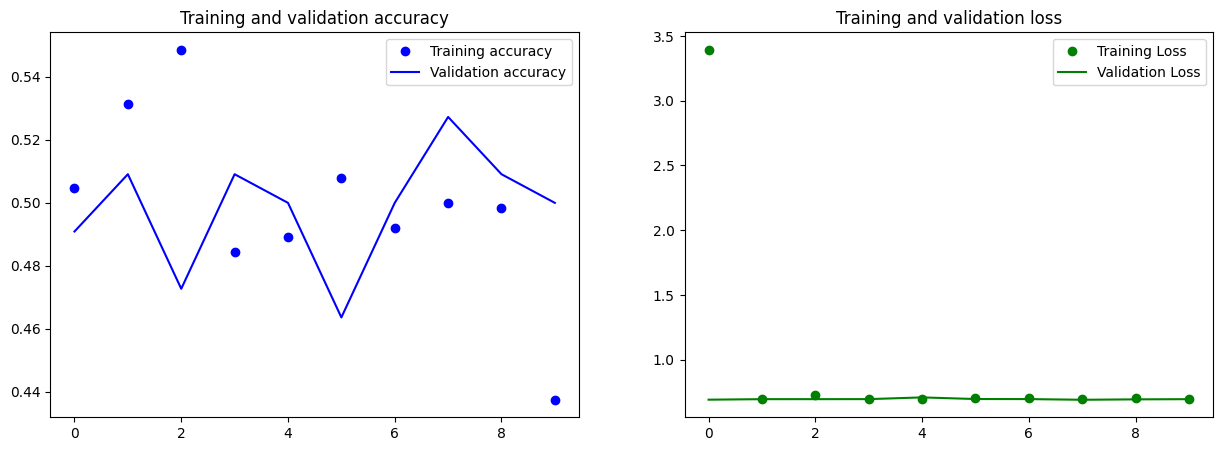

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()


plt.subplot(1,2,2)
plt.plot(epochs, loss, 'go', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()